### Overview

This is a personal project I undertook to detect american sign language in images. I downloaded images from https://public.roboflow.com/object-detection/american-sign-language-letters/1/download/yolov5pytorch for this notebook


In [113]:
import os
import numpy as np
import torch
from PIL import Image
import pandas as pd
import cv2
from pathlib import Path
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor


In [115]:
# confirm that the CUDA is available
torch.cuda.is_available()

True

Helper functions for generating the pandas DF and resizing images to the same size.

In [117]:
def list_files(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def get_image_sizes(file_list):
    heights = []
    widths = []
    
    for file in file_list:
        height, width, _ = cv2.imread(file).shape
        heights.append(height)
        widths.append(width)
        
    return heights, widths

def resize_images(image_list, size, save_dir):
    for image in image_list:
        img = cv2.imread(image)
        img_resized = cv2.resize(img, (size, size))
        
        new_path = save_dir+image.split("/")[-1]
        cv2.imwrite(new_path, img_resized)


In [119]:
train_dir = "./data/ASL/train/labels"
file_path = "txt"

training_list = []

files = list_files(train_dir, file_path)
for file in files:
    f = open(file, "r")
    target_class, x_min, y_min, x_max, y_max = f.read().split(" ")
    training_list.append([file, target_class, x_min, y_min, x_max, y_max])
    
image_dir = "./data/ASL/train/images/"
file_path = "jpg"

image_files = list_files(image_dir, file_path)
heights, widths = get_image_sizes(image_files)

In [120]:
img_size = max(heights)

In [121]:
resized_image_dir = "./data/ASL/train/resized_images"
resize_images(image_files, img_size, resized_image_dir)

In [122]:
resized_image_files = list_files(resized_image_dir, file_path)

In [123]:
training_df = pd.DataFrame(training_list)
training_df.columns = ["path", "target_class","x_center", "y_center", "width", "height"]
training_df["image_path"] = image_files
training_df["resized_image_path"] = resized_image_files
training_df["image_width"] = widths
training_df["image_height"] = heights

# Update the x_center and y_center relative to their

training_df["x_min"] = (training_df["x_center"].astype(float) - training_df["width"].astype(float).multiply(0.5))*training_df["image_width"]
training_df["x_max"] = (training_df["x_center"].astype(float) + training_df["width"].astype(float).multiply(0.5))*training_df["image_width"]

training_df["y_min"] = (training_df["y_center"].astype(float) - training_df["height"].astype(float).multiply(0.5))*training_df["image_height"]
training_df["y_max"] = (training_df["y_center"].astype(float) + training_df["height"].astype(float).multiply(0.5))*training_df["image_height"]

bounding_boxes = []

for index, row in training_df.iterrows():

    bb = np.array([round(float(row["x_min"])), round(float(row["y_min"])), round(float(row["x_max"])), round(float(row["y_max"]))])
    bounding_boxes.append(bb)

training_df["bbs"] = bounding_boxes
# training_df.head()

In [124]:
# I have an available GPU to run this notebook in

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [125]:
X = training_df[["resized_image_path", "bbs"]]
y = training_df["target_class"]

num_classes = len(set(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=34)

In [126]:
from torchvision import transforms

normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

train_transform = transforms.Compose([
            transforms.Resize((img_size, img_size))
        ])

In [127]:
class ASLDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, bb, img_labels, transform=None, target_transform=None):
        self.image_dir = image_dir.values
        self.bb = bb.values
        self.img_labels = img_labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):

        image = read_image(self.image_dir[idx])

        label = int(self.img_labels.iloc[idx])
        bb = self.bb[idx]

        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label, bb

    
batch_size = 16

train_ds = ASLDataset(X_train['resized_image_path'], X_train['bbs'], y_train, transform=None)
valid_ds = ASLDataset(X_test['resized_image_path'], X_test['bbs'], y_test)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [237]:
train_ds[0][0].shape

torch.Size([3, 416, 416])

In [128]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], color=color, fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [129]:
image_index = 72
training_df.iloc[image_index]
bbs = training_df.iloc[image_index]["bbs"]

We'll show a sample image to confirm we can read from the dataframe:

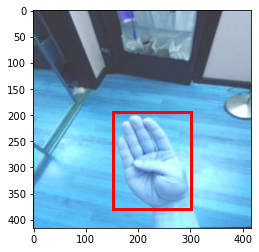

In [130]:
color = "red"
img = cv2.imread(training_df.iloc[image_index]["image_path"])
img = cv2.resize(img, (img_size, img_size))

plt.imshow(img)
plt.gca().add_patch(create_corner_rect(training_df.iloc[image_index]["bbs"]))

In [131]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = len(set(y))

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for 
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

In [132]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [141]:
class BB(nn.Module):
    def __init__(self):
        super(BB, self).__init__()
        self.resnet = models.resnet34(pretrained=True)
        num_ftrs = self.resnet.fc.out_features
        
        self.classifier = nn.Linear(num_ftrs, num_classes)
        self.bb = nn.Sequential(nn.BatchNorm1d(num_ftrs), nn.Linear(num_ftrs, 4))

    def forward(self, x):
        x = self.resnet(x)
        # x = F.relu(x)
        # x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [142]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [143]:

def train_epochs(model, optimizer, train_dl, val_dl, epochs=10, C=1000):
    idx = 0
    
    model.cuda()
    
    for i in range(epochs):
        
        print(i)
        
        model.train()
        
        total = 0
        sum_loss = 0

        for x, y_class, y_bb in train_dl:
            
            x, y_class, y_bb = x.to(device), y_class.to(device), y_bb.to(device)
        
            batch = y_class.shape[0]
            x = x.float()
            y_bb = y_bb.float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")

            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            idx += 1
            total += batch
            sum_loss += loss.item()
            
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        if (i+1) % 10 == 0:
            print("i:%4d train_loss:%5.3f val_loss:%5.3f val_acc:%5.3f" % ((i+1), train_loss, val_loss, val_acc))
    return sum_loss/total

In [144]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        
        x, y_class, y_bb = x.to(device), y_class.to(device), y_bb.to(device)

        batch = y_class.shape[0]
        x = x.float()
        y_bb = y_bb.float()
        out_class, out_bb = model(x)
        
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [145]:
model = BB()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.002)

In [147]:
torch.cuda.empty_cache()

In [148]:
train_epochs(model, optimizer, train_dl, valid_dl, epochs=500)

0
1
2
3
4
5
6
7
8
9
i:  10 train_loss:3.317 val_loss:19.477 val_acc:0.070
10
11
12
13
14
15
16
17
18
19
i:  20 train_loss:3.121 val_loss:3.630 val_acc:0.108
20
21
22
23
24
25
26
27
28
29
i:  30 train_loss:2.881 val_loss:3.374 val_acc:0.130
30
31
32
33
34
35
36
37
38
39
i:  40 train_loss:2.087 val_loss:2.535 val_acc:0.326
40
41
42
43
44
45
46
47
48
49
i:  50 train_loss:1.145 val_loss:3.616 val_acc:0.311
50
51
52
53
54
55
56
57
58
59
i:  60 train_loss:0.657 val_loss:1.954 val_acc:0.579
60
61
62
63
64
65
66
67
68
69
i:  70 train_loss:0.286 val_loss:1.774 val_acc:0.681
70
71
72
73
74
75
76
77
78
79
i:  80 train_loss:0.117 val_loss:1.575 val_acc:0.720
80
81
82
83
84
85
86
87
88
89
i:  90 train_loss:0.240 val_loss:3.971 val_acc:0.456
90
91
92
93
94
95
96
97
98
99
i: 100 train_loss:0.247 val_loss:2.265 val_acc:0.630
100
101
102
103
104
105
106
107
108
109
i: 110 train_loss:0.086 val_loss:1.958 val_acc:0.707
110
111
112
113
114
115
116
117
118
119
i: 120 train_loss:0.067 val_loss:1.457 val_acc

0.2658227194234419

### Prediction

In [340]:
# Change this to see different predictions
predict_idx = 2

In [341]:
x_image_sample, x_bb_sample = X_test.iloc[predict_idx]

In [342]:
y_sample = y_test.iloc[predict_idx]

In [344]:
img = cv2.imread(x_image_sample)

xx = torch.cuda.FloatTensor(img[None,])

In [345]:
x_transformed = xx.view(1, 3, 416, 416)

In [346]:
out_class, out_bb = model(x_transformed)

(tensor([[-13.7968, -10.2428,  -3.1530,   6.0009, -11.1677,   2.1090,  -4.8279,
            1.0778,  -2.7403,  -6.5672,  10.8627,   6.6547,  -3.6329,  -8.7356,
            4.0529,  20.0981,  11.0002,  12.1051,  -6.4055, -16.0268,   4.2346,
           -5.5695,  -3.5305,   2.5369, -15.1724,   7.1301]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[ 62.5023,   0.5563, 328.6720, 357.8802]], device='cuda:0',
        grad_fn=<AddmmBackward>))

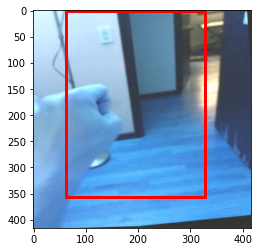

In [347]:
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(img, bb_hat[0])

In [348]:
out_class

tensor([[-13.7968, -10.2428,  -3.1530,   6.0009, -11.1677,   2.1090,  -4.8279,
           1.0778,  -2.7403,  -6.5672,  10.8627,   6.6547,  -3.6329,  -8.7356,
           4.0529,  20.0981,  11.0002,  12.1051,  -6.4055, -16.0268,   4.2346,
          -5.5695,  -3.5305,   2.5369, -15.1724,   7.1301]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [349]:
def softmax(x):
    assert len(x.shape) == 2
    s = np.max(x, axis=1)
    s = s[:, np.newaxis] # necessary step to do broadcasting
    e_x = np.exp(x - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis]
    return e_x / div

In [350]:
norm_max = softmax(out_class.cpu().detach().numpy())
predicted_class = np.array(norm_max).argmax()
predicted_class

15

In [351]:
actual_class = y_test.iloc[[predict_idx]]
actual_class

603    9
Name: target_class, dtype: object